In [50]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import pandas as pd

In [51]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import *
from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [52]:
k_nei=10
K=3
L=2
normalized=0
seed = 0

if seed is not None:
    reset_seeds(seed)

In [53]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())

2.0.1+cpu
None
False
0


In [54]:
data_path='data/'
result_path='results/'

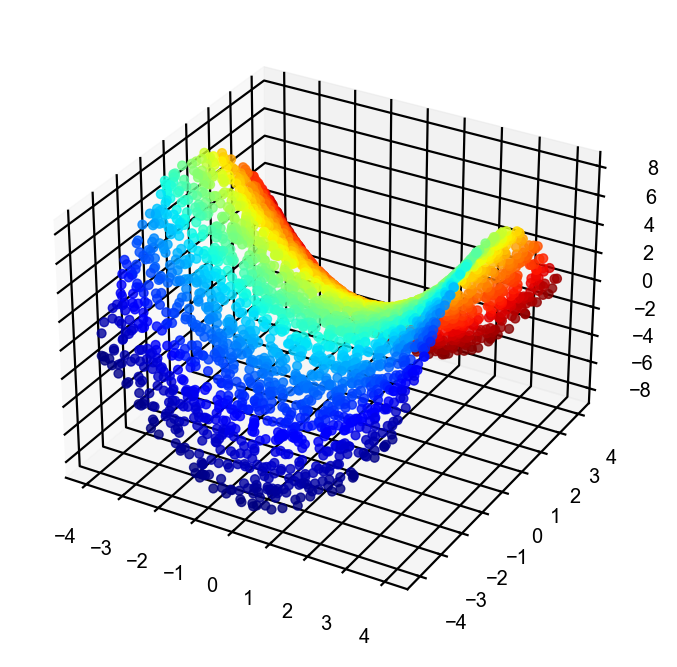

In [55]:
#-------saddle-----------

n_samples=3000
X_minor=0.1*np.random.randn(n_samples,7)

roi=np.linspace(-4,4,10000)

x1=np.random.choice(roi,n_samples)
x2=np.random.choice(roi,n_samples)
color_label=np.zeros((n_samples))
color_label[np.argsort(x2)]=np.arange(n_samples)

x3 = 0.5*((x1)**2 - (x2)**2)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
plt.show()

X_major=np.array([x1,x2,x3]).T
X=np.hstack((X_major,X_minor))

In [56]:
A = kneighbors_graph(X, k_nei, mode='connectivity', include_self=True)

def embed_dist_compare(A,X,em_X):
    dist_ratios=[]
    for ori_inds in np.split(A.indices, A.indptr)[1:-1]:
        dist_r=[]
        self_ind=ori_inds[0]
        for nei_k in range(1,len(ori_inds)):

            dEu=np.linalg.norm(X[self_ind,:]-X[ori_inds[nei_k],:])


            em_dEu=np.linalg.norm(em_X[self_ind,:]-em_X[ori_inds[nei_k],:]) 
            dist_r.append(dEu/em_dEu)
#         print(np.std(dist_r)/np.mean(dist_r))
        dist_ratios.append(np.std(dist_r)/np.mean(dist_r))
    return np.array(dist_ratios)

# PCA

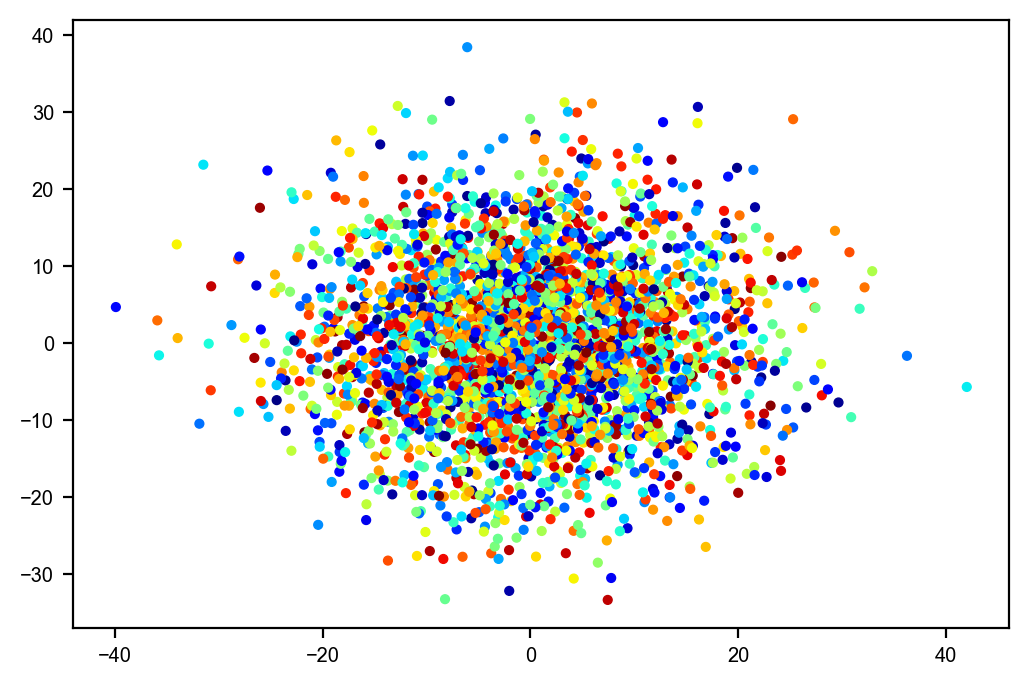

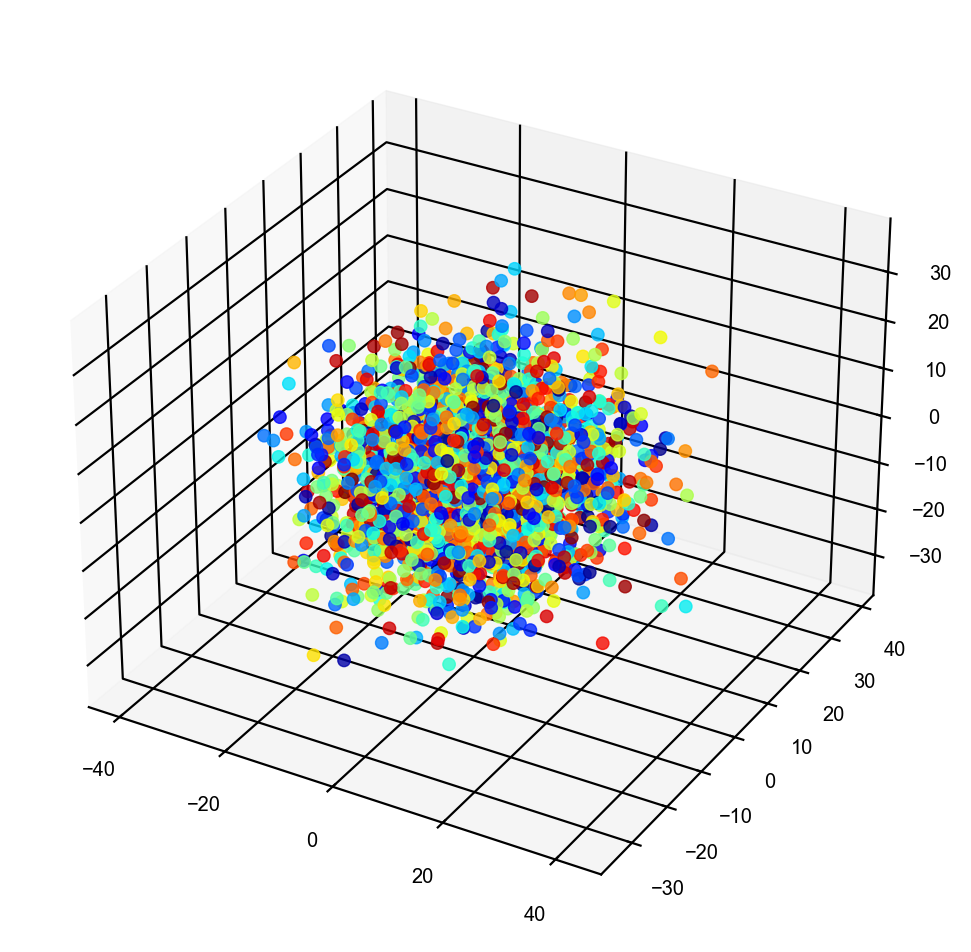

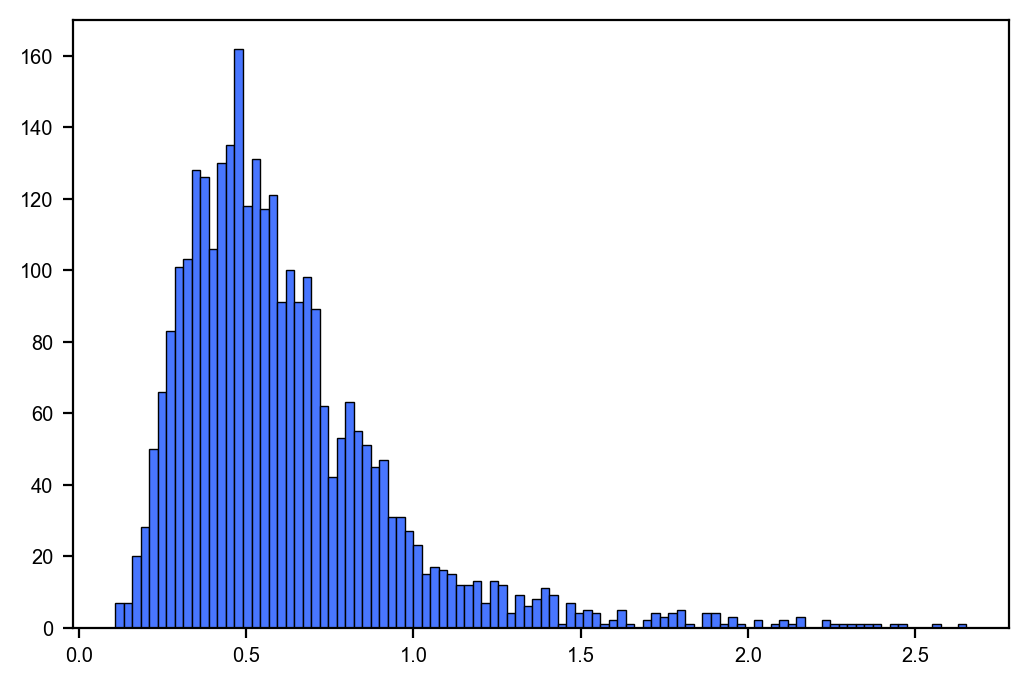

In [57]:
pca=PCA(n_components=3).fit(X)
X_pca=pca.transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_pca[:, 0],X_pca[:, 1], X_pca[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

ratio_compare=embed_dist_compare(A,X,X_pca[:,:2])
plt.hist(ratio_compare,bins=100,edgecolor='black')
plt.show()

# LassoNet Gaussian Embedding

In [58]:
epochs = 5000
nsamples = 5
learning_rate = 1e-3
# seed = 1 # seed is reset at the beginning
# n_workers = 4
K = K# !!!!!!!!!! K should be large enough


# if seed is not None:
#     reset_seeds(seed)

A=A.astype(np.float32)
X=X.astype(np.float32)
# X=Xs/np.mean(np.abs(Xs),axis=0)
# X=adata.X.A
#--------do not normalize X
# scaler=StandardScaler()#
# X=scaler.fit_transform(X0_ori)
z=color_label

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

L = L
# L = np.load('results/latent_dim.npy')
encoder = LassoEncoder(X.shape[1], L, M=10)

In [59]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs #// n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
#     num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [60]:
# 每次变lambda之后重启dataloader

# dim = 3

# lambda_seq = np.concatenate(([0],0.1*np.logspace(0,2,30)))
# # lambda_seq = [0]

# hist_opt = np.inf
# hist_opt_idx = 0

# for lambda_ in lambda_seq:
#     encoder.lambda_ =lambda_
#     batch_idx = 0
    
#     if encoder.selected_count() == dim:
#          break
    
#     for batch_idx, data in enumerate(loader):
#         encoder.train()
#         optimizer.zero_grad()

#         loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])

#         if batch_idx == 0:
#              hist_opt = loss
#              hist_opt_idx = batch_idx

#         # early stopping
#         if loss < hist_opt:
#             hist_opt = loss
#             hist_opt_idx = batch_idx
#         elif hist_opt_idx+10 < batch_idx:
#             break

#         if batch_idx% 10 == 0:
#             print(f"lambda = {lambda_}, batch = {batch_idx}, loss = ",loss, f" skip_l1 = {encoder.l1_regularization_skip()}, feature_number = {encoder.selected_count()}")
#         loss.backward()
#         optimizer.step()
#         encoder.prox()

#         if encoder.selected_count() == dim:
#             break

In [85]:
# 每次变lambda之后不重启dataloader

dim = 3

hist_opt = np.inf
hist_opt_idx = 0
    
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])

    if batch_idx == 0:
            hist_opt = loss
            hist_opt_idx = batch_idx

    # early stopping
    if loss < hist_opt:
        hist_opt = loss
        hist_opt_idx = batch_idx
    elif hist_opt_idx+10 < batch_idx:
        if encoder.lambda_:
            encoder.lambda_ *= 1.1
        else:
             encoder.lambda_ = 0.1
        hist_opt_idx = batch_idx
        hist_opt = loss

    if batch_idx% 10 == 0:
        print(f"lambda = {encoder.lambda_}, batch = {batch_idx}, loss = ",loss, f" skip_l1 = {encoder.l1_regularization_skip()}, feature_number = {encoder.selected_count()}")
    loss.backward()
    optimizer.step()
    encoder.prox()

    if encoder.selected_count() <= dim:
        break

lambda = 0.5559917313492238, batch = 0, loss =  tensor(1.8836e+09, grad_fn=<DivBackward0>)  skip_l1 = 0.0004211114428471774, feature_number = 2


In [86]:
(torch.norm(encoder.skip.weight.data, p=2, dim=0).numpy()==0).sum()

9

In [87]:
(torch.norm(encoder.linear1.weight.data, p=2, dim=0).numpy()==0).sum()

9

# True是被选择的维度

In [88]:
encoder.input_mask()

tensor([False, False, False, False, False, False, False, False,  True, False])

In [89]:
# torch.save(encoder,'results/encoder.pt')
# torch.save(encoder,'results/L='+str(L)+',K='+str(K)+'.pt')

In [90]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

In [91]:
cRc_arr=[]
cRc_arr_eu=[]

for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)

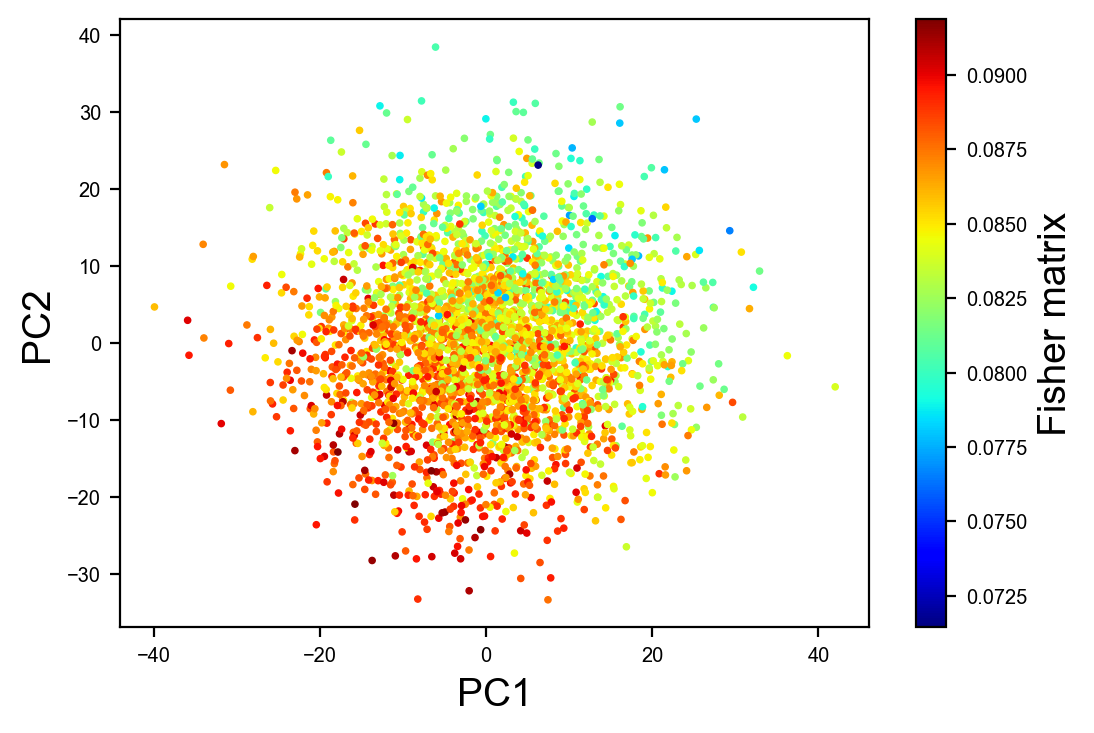

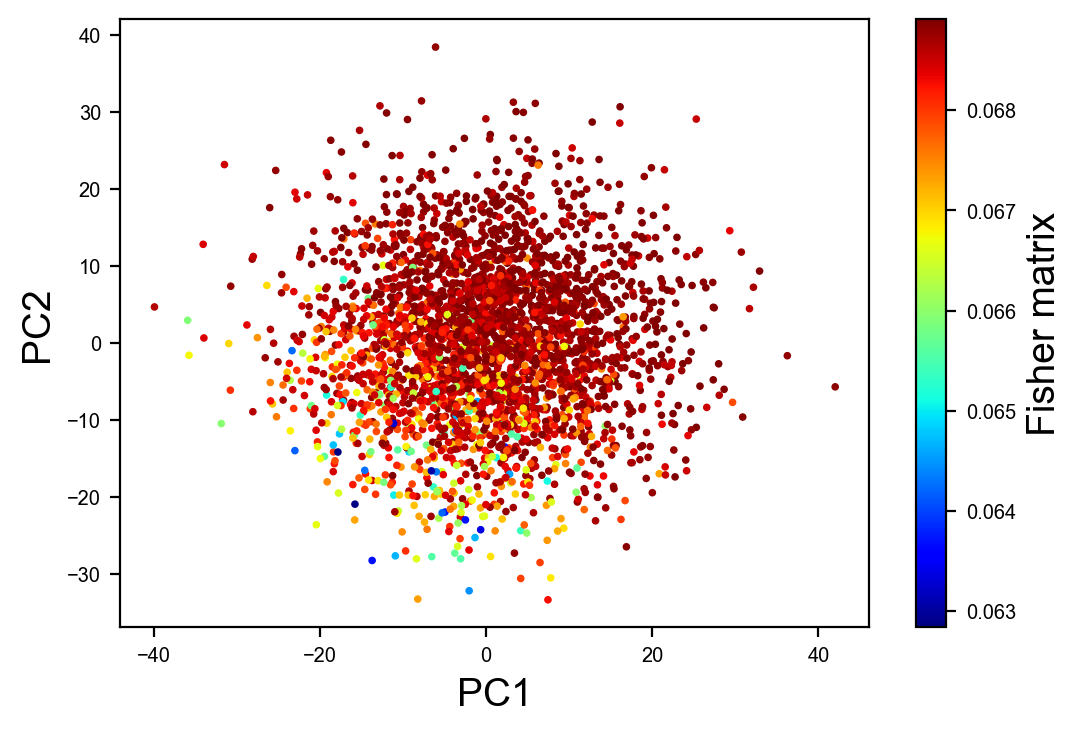

In [92]:
for i in range(L):
    plt.scatter(X_pca[:,0],X_pca[:,1],s=5,c=Fisher_g[:,i,i],cmap=plt.cm.jet)
    plt.xlabel('PC1',fontsize=14)
    plt.ylabel('PC2',fontsize=14)
    
    clb=plt.colorbar()
    clb.ax.set_ylabel('Fisher matrix',fontsize=14)
    # plt.savefig(result_path+'g_'+str(i)+'.png')
    plt.show()

# smooth

In [93]:
cell_nei = A.indices.reshape([-1,10])
cell_nei

nei_w=[]
rho_arr=[]
row =np.array([np.ones((k_nei,))*i for i in range(X.shape[0])]).flatten()
col=cell_nei.flatten()
w_val=np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
dc=np.amax(w_val)
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)

cRc_arr_eu = np.array(cRc_arr_eu)

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

cRc_arr_eu_smooth = smooth_func(cRc_arr_eu)

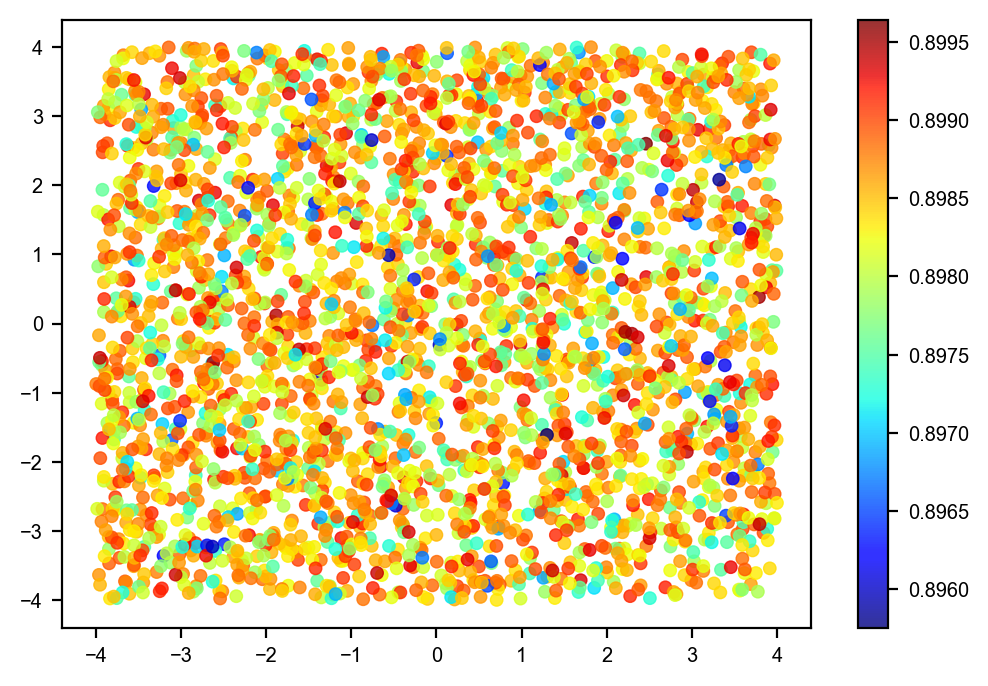

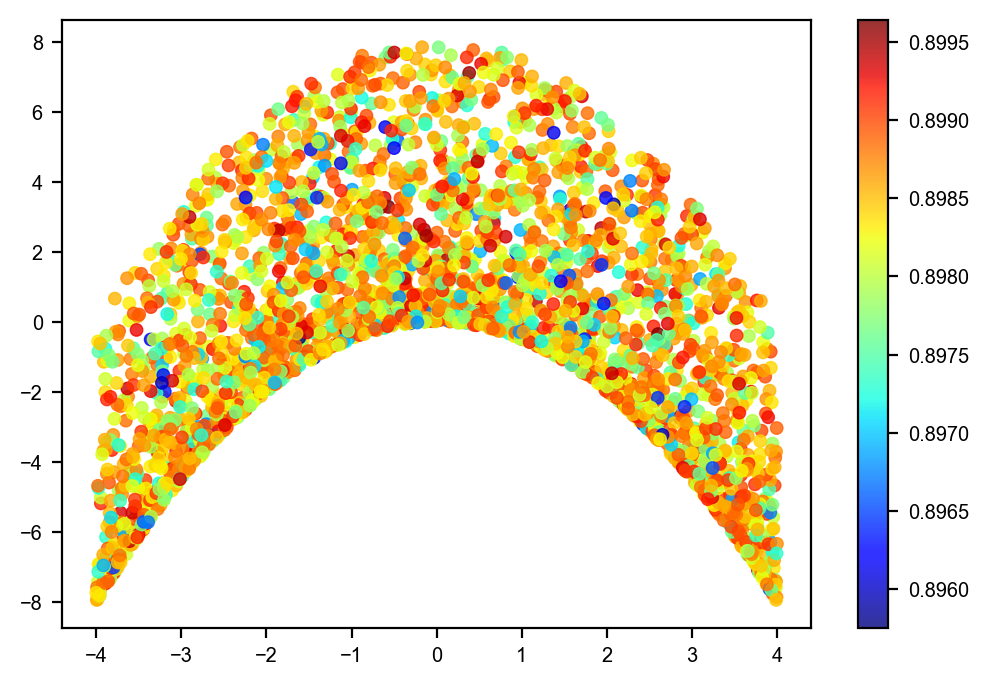

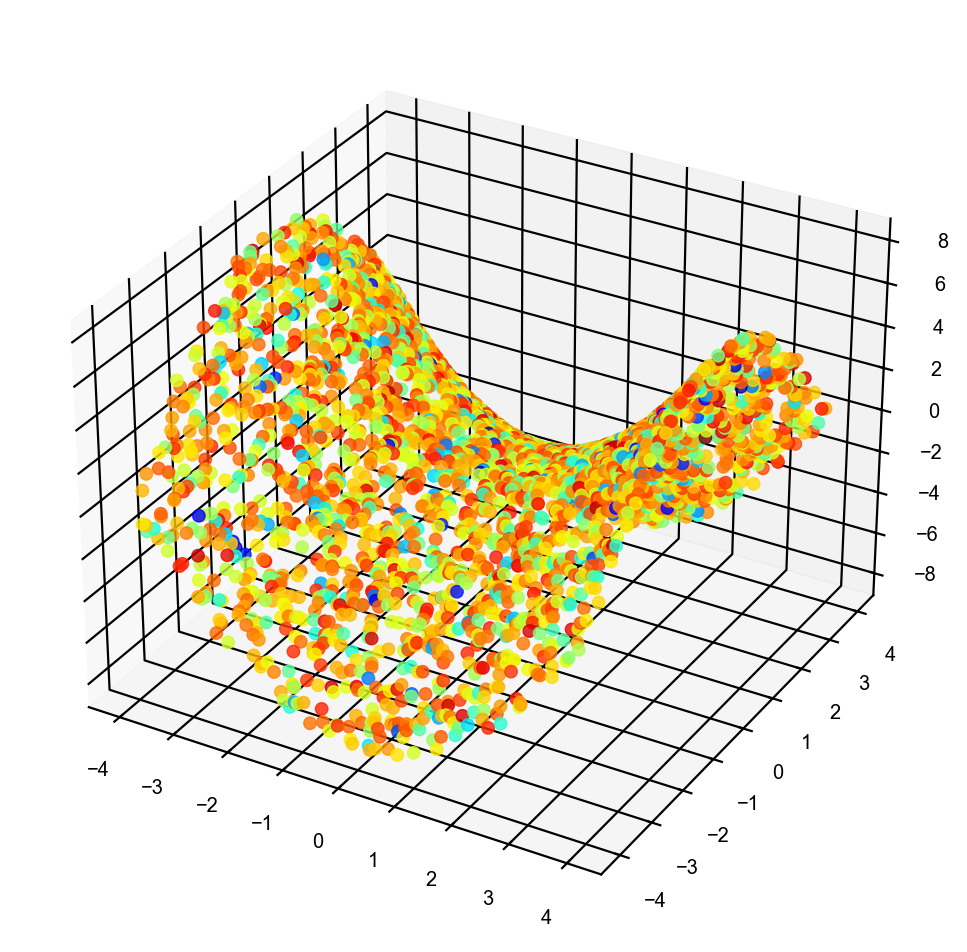

In [94]:
plt.scatter(X[:, 0],X[:, 1], c=cRc_arr_eu, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("coscos 1")
plt.show()

plt.scatter(X[:, 1],X[:, 2], c=cRc_arr_eu, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=cRc_arr_eu, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.savefig("coscos 2")
plt.show()

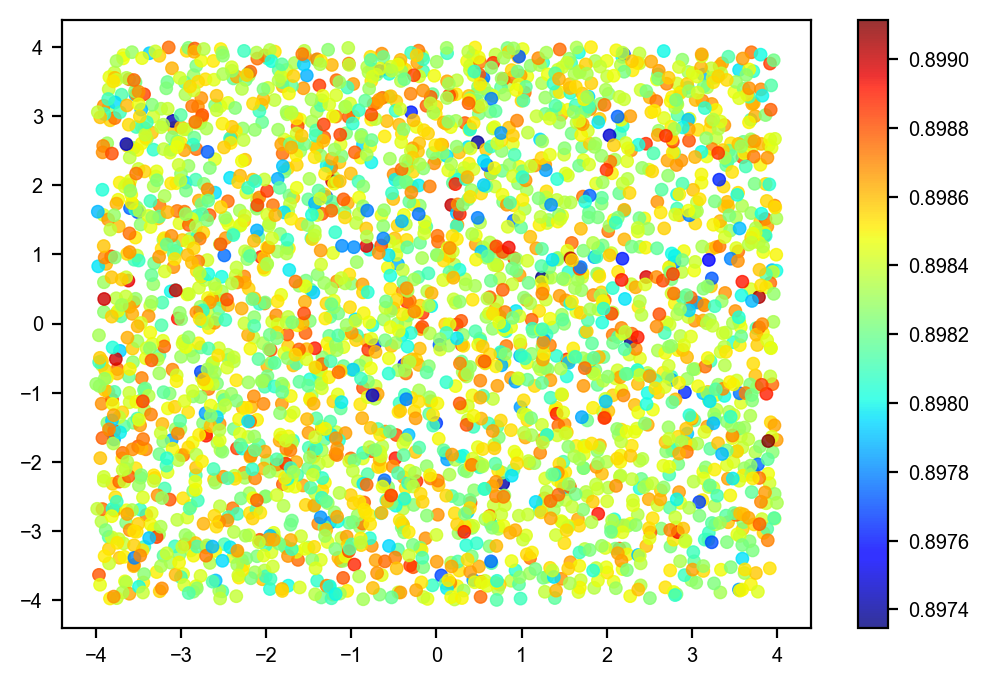

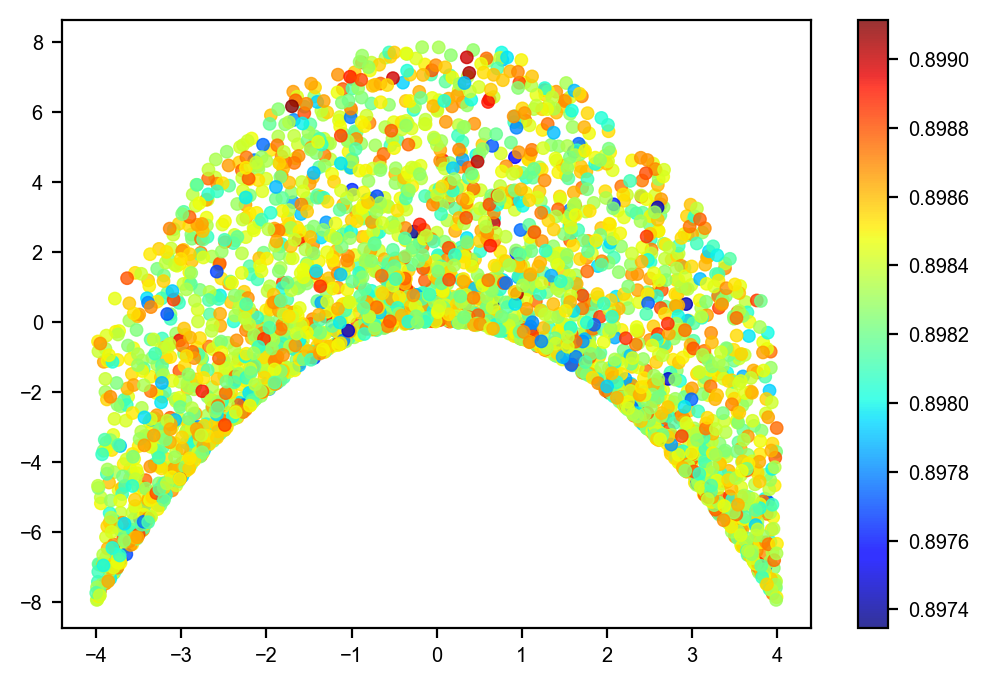

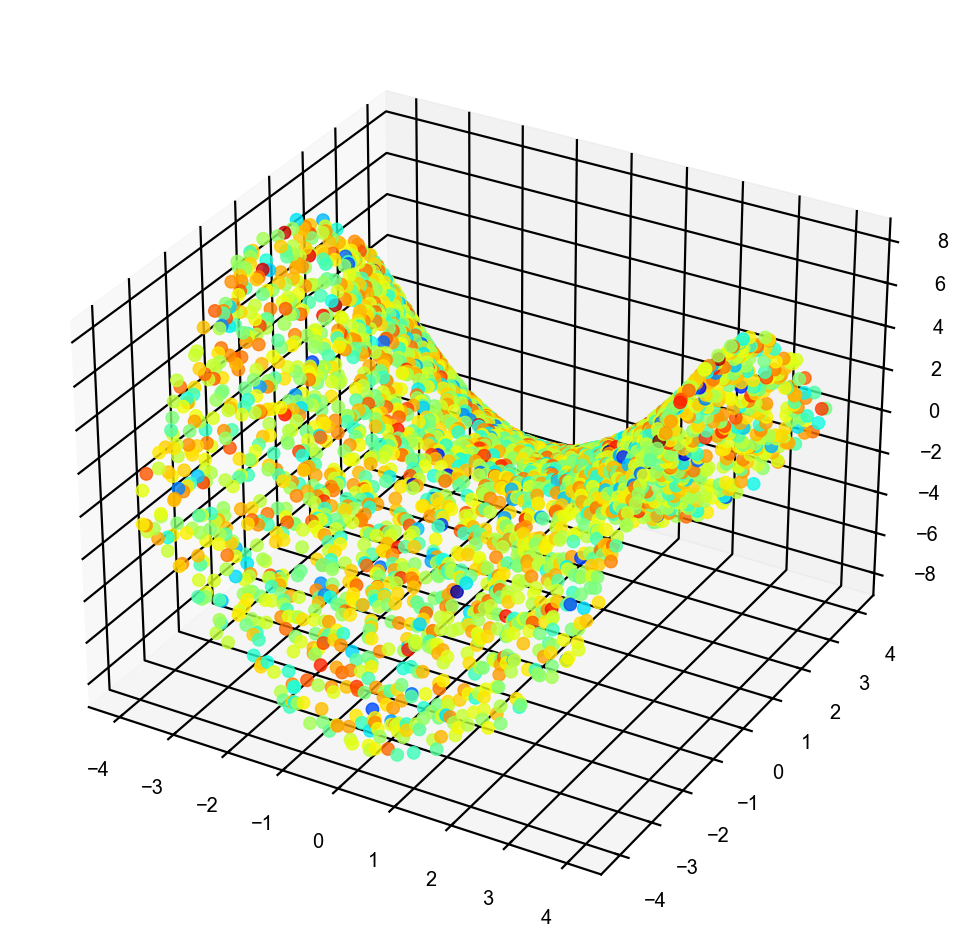

In [95]:
plt.scatter(X[:, 0],X[:, 1], c=cRc_arr_eu_smooth, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("coscos smooth 1")
plt.show()

plt.scatter(X[:, 1],X[:, 2], c=cRc_arr_eu_smooth, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=cRc_arr_eu_smooth, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.savefig("coscos smooth 2")
plt.show()

In [96]:
encoder.input_mask()

tensor([False, False, False, False, False, False, False, False,  True, False])